In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import regex as re
from nltk.stem import PorterStemmer

In [2]:
def plot_data(dataset,labels):
    X,y = dataset[:,0:-1],dataset[:,-1]
    length = len(X)
    pos = (y==labels[1]).reshape(length,1)
    neg = (y==labels[0]).reshape(length,1)
    plt.scatter(dataset[pos[:,0],0],dataset[pos[:,0],1],c='red',marker='+')
    plt.scatter(dataset[neg[:,0],0],dataset[neg[:,0],1],c='blue',marker='x')
    
    plt.show()

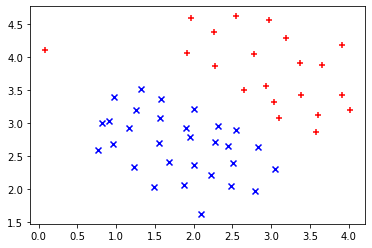

In [3]:
def load__plot_data():
    data = loadmat("datasets/svm_sample.mat")
    X,y = data['X'],data['y']
    y = y.astype(float)
    y[y==0]=-1
    #plot the data
    dataset = np.append(X,y,axis=1)
    labels = np.unique(dataset[:,-1])
    plot_data(dataset,labels)
    
    return X,y,dataset,labels

X,y,dataset,labels = load__plot_data()

In [6]:
def standardize_input(X):
    X_mean = np.mean(X,axis=0)
    X_std = np.std(X,axis=0)
    
    X_norm = (X - X_mean)/X_std
    
    return X_norm

X_norm = standardize_input(X)

In [7]:
def Initialize_params(X,m):
    X = np.append(np.ones((m,1)),X,axis=1)
    w = np.zeros((X.shape[1],1))
    
    return X,w

In [8]:
X,w = Initialize_params(X_norm,len(X_norm))

In [9]:
def Cost_fn(X,y,w,C):
    distance = 1 - y*np.dot(X,w)
    distance[distance < 0] = 0
    N =len(y)
    hinge_loss = (C * np.sum(distance))/N
    cost = (1/2) * np.dot(w.T,w) + hinge_loss
    return float(cost[0])

In [10]:
def gradient(X,y,w,C):
    output = 1 - y*np.dot(X,w)
    dw = np.zeros((len(w),1))
    for i,out in enumerate(output):
        if max(0,out) == 0:
            di = w
        else:
            di = w - C*y[i]*X[i].reshape(X.shape[1],1)
        dw += di
        
    return dw/len(y)

In [11]:
def Train_algo(X,y,w,ephocs,C,alpha):
    J = []
    w = np.zeros((X.shape[1],1))
    for i in range(ephocs):
        dw = gradient(X,y,w,C)
        w = w - alpha*dw
        J.append(Cost_fn(X,y,w,C))
    
    return J,w

In [12]:
C = 1
alpha = 0.1
iterations = 100
J,w = Train_algo(X,y,w,iterations,C,alpha)

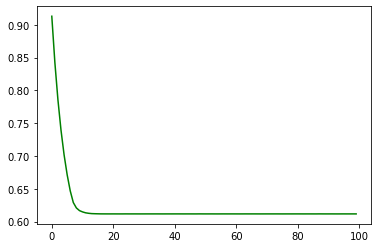

In [13]:
ephocs = [i for i in range(iterations)]
plt.plot(ephocs,J,color='green')
plt.show()

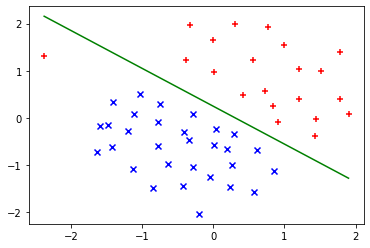

In [14]:
#plot the fit along with data
def plot_fit(X,y,labels,weights):
    length = len(X)
    pos = (y==labels[1]).reshape(length,1)
    neg = (y==labels[0]).reshape(length,1)
    plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c='red',marker='+')
    plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c='blue',marker='x')
    
    x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
    y_value = -(weights[0] + weights[1]*x_value)/weights[2]
    
    plt.plot(x_value,y_value,c='green')
    
    plt.show()

plot_fit(X,y,labels,w)

In [15]:
#Calculate accuracy on the training set
y1 = np.sign(np.dot(X,w))

print("The accuracy for the training set:",np.mean(y1==y)*100)

The accuracy for the training set: 98.0392156862745


## Spam Classifier 

### Using Built In library

In [16]:
d = loadmat("datasets/spamTrain.mat")

In [17]:
X,y = d['X'],d['y']

In [18]:
from sklearn.svm import SVC
C =0.1
spam_svc = SVC(C=0.1,kernel ="linear")
spam_svc.fit(X,y.ravel())
print("Training Accuracy:",(spam_svc.score(X,y.ravel()))*100,"%")

Training Accuracy: 99.825 %


In [19]:
testdata = loadmat("datasets/spamTest.mat")
Xtest,ytest = testdata['Xtest'],testdata['ytest']

In [20]:
spam_svc.predict(Xtest)
print("Test Accuracy:",(spam_svc.score(Xtest,ytest.ravel()))*100,"%")

Test Accuracy: 98.9 %


In [21]:
spam_svc.coef_,spam_svc.intercept_

(array([[ 0.00793208,  0.01563324,  0.05546492, ..., -0.08670606,
         -0.00661274,  0.06506632]]),
 array([0.18632764]))

### My Train Logic

In [22]:
# Read the dataset
X,y = d['X'],d['y']

# Convert the label 0 to label -1
y = y.astype(float)
y[y==0] = -1

In [23]:
X,w = Initialize_params(X,len(X))

In [24]:
#Hyperparameters
C = 10
alpha = 0.003
ephocs = 100


In [25]:
# Get trained weights
J,w = Train_algo(X,y,w,ephocs,C,alpha)

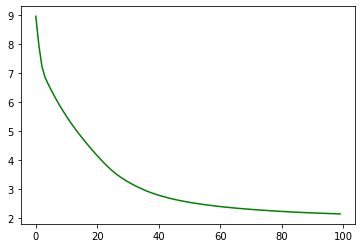

In [26]:
# Plot the cost function
e = [i for i in range(ephocs)]
plt.plot(e,J,color='green')
plt.show()

In [27]:
# Calculate the Training Accuracy
ypred_train = np.sign(np.dot(X,w))

print("Training Accuracy:",np.mean(y == ypred_train)*100)

Training Accuracy: 96.125


In [28]:
# Test the accuracy on the test set

Xtest,ytest = testdata['Xtest'],testdata['ytest']

ytest = ytest.astype(float)
ytest[ytest==0] = -1

Xtest = np.append(np.ones((len(Xtest),1)),Xtest,axis=1)

ypred_test = np.sign(np.dot(Xtest,w))

print("Testing Accuracy:",np.mean(ytest == ypred_test)*100)

Testing Accuracy: 96.6


## Creating feature Vectors from email

In [29]:
import os

with open("datasets/emailSample1.txt") as sample:
    email_contents = sample.read()
    

In [30]:
def getVocabList():
    vocab = pd.read_csv("datasets/vocab.txt",sep='\t',header=None)
    return list(vocab.iloc[:,1])

In [31]:
def processEmail(emailContents):
    
    word_indices = []
    
    #get vocab list
    vocab = getVocabList()
    
    #lower all the size of each texts
    emailContents = emailContents.lower()
    
    #remove any html tags
    emailContents = re.compile('<[^<>]+>').sub(' ', emailContents)
    
    #normalizing the URL
    emailContents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ',emailContents)
    
    #normalizing the email address
    emailContents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ',emailContents)
    
    #normalize the numbers
    emailContents = re.compile('[0-9]+').sub(' numbers ',emailContents)
    
    #normalize the dollars
    emailContents = re.compile('[$]+').sub(' dollar ',emailContents)
    
    emailContents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', emailContents)
    
    # remove any empty word
    emailContents = [word for word in emailContents if len(word) > 0]
    
    #stem the email content word by word
    stemmer = PorterStemmer()
    
    for word in emailContents:
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        
        if len(word) < 1:
            continue
        try:
            word_indices.append(vocab.index(word))
            
        except ValueError:
            pass
        
    return word_indices

In [32]:
word_indices = processEmail(email_contents)

In [33]:
def generate_featureVector(word_indices):
    #The vocab list denotes the total number of features
    n = 1899
    feature_vec = np.zeros((n,1))
    
    for each in word_indices:
        feature_vec[each] = 1
        
    return feature_vec

In [34]:
#The feature vector for the above email sample is:
feature_vector = generate_featureVector(word_indices)

In [35]:
#Predict if the feature vector generated is spam or non spam
feature_vector = feature_vector.reshape(1,feature_vector.shape[0])
featureVec = np.append(np.ones((feature_vector.shape[0],1)),feature_vector,axis=1)

featureVec.shape

(1, 1900)

In [36]:
output = np.sign(np.dot(featureVec,w))
pred = float(output[0])

#for the given email sample, from human labelling it is expected to be a non spam email
if pred == 1:
    print("The sample email predicted is spam")
else:
    print("The sample email predicted is non spam")

The sample email predicted is non spam


In this way, we can generate features for all email samples and then use the model built above to predict if the email is spam or non spam